<a href="https://colab.research.google.com/github/GeorgeNance/ml-research/blob/master/pokemon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install -Uqq fastai duckduckgo_search ipywidgets gradio timm

In [9]:
from duckduckgo_search import ddg_images
from fastcore.all import *
from fastai.vision.widgets import *
from fastai.vision.all import *
from fastdownload import download_url
from fastai.data.transforms import GrandparentSplitter

def search_images(term, max_images=50):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [1]:
import zipfile

data_folder = "data/pokemon"

with zipfile.ZipFile("train.zip","r") as zip_ref:
    zip_ref.extractall(data_folder+"/train")

with zipfile.ZipFile("valid.zip","r") as zip_ref:
    zip_ref.extractall(data_folder+"/valid")

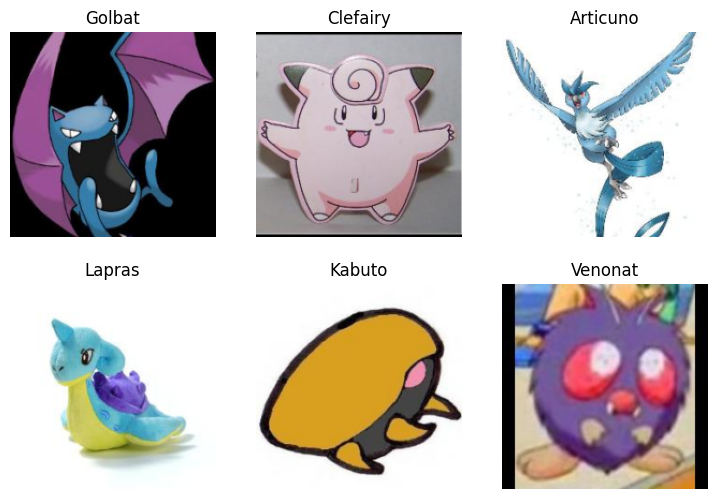

In [10]:
path = Path('data/pokemon')
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=117),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [5]:
# Messing with models
import timm

In [8]:
timm.list_models("convnext*")

['convnext_atto',
 'convnext_atto_ols',
 'convnext_base',
 'convnext_femto',
 'convnext_femto_ols',
 'convnext_large',
 'convnext_large_mlp',
 'convnext_nano',
 'convnext_nano_ols',
 'convnext_pico',
 'convnext_pico_ols',
 'convnext_small',
 'convnext_tiny',
 'convnext_tiny_hnf',
 'convnext_xlarge',
 'convnext_xxlarge',
 'convnextv2_atto',
 'convnextv2_base',
 'convnextv2_femto',
 'convnextv2_huge',
 'convnextv2_large',
 'convnextv2_nano',
 'convnextv2_pico',
 'convnextv2_small',
 'convnextv2_tiny']

In [11]:
learn = vision_learner(dls, 'convnextv2_tiny', metrics=error_rate)
learn.fine_tune(20)

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,2.856163,1.092780,0.259871,00:28


epoch,train_loss,valid_loss,error_rate,time
0,0.896265,0.710207,0.159368,00:35
1,0.557912,0.514953,0.122757,00:35
2,0.321549,0.395792,0.096913,00:35
3,0.193532,0.365471,0.099785,00:35
4,0.114821,0.287465,0.081120,00:35
5,0.099274,0.310009,0.078966,00:35
6,0.078682,0.288464,0.071788,00:35
7,0.051693,0.257985,0.064609,00:35
8,0.031373,0.271569,0.066045,00:35
9,0.035496,0.276730,0.070352,00:35


In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

# Testing

Searching for 'pidgey scene pokemon movie 22'


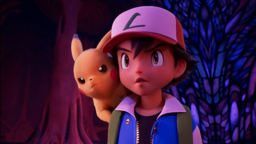

In [24]:
download_url(search_images('pidgey scene pokemon movie 22', max_images=1)[0], 'test.jpg', show_progress=False)
Image.open('test.jpg').to_thumb(256,256)

In [37]:




results = predict(PILImage.create('test.jpg'))
# Sort the dicts values by highest probability and show top 3 with highest probability
sorted(results, key=results.get, reverse=True)[:3]


['Spearow', 'Vulpix', 'Vileplume']

In [12]:
learn.export("models/pokemon-20-conv2.pkl")

# Gradio

In [13]:
#|export
learn = load_learner('models/pokemon-20-conv2.pkl')
labels = learn.dls.vocab

def predict(img):
    img = PILImage.create(img).to_thumb(256,256)
    pred,pred_idx,probs = learn.predict(img)
    return {labels[i]: float(probs[i]) for i in range(len(labels))}


import gradio as gr

iface = gr.Interface(
    fn=predict, 
    inputs=gr.Image(), 
    outputs=gr.Label(num_top_classes=3)
)

iface.launch(share=True)


Running on local URL:  http://127.0.0.1:7861
Running on public URL: https://dcfad68226e125f3e7.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Traceback (most recent call last):
  File "c:\Users\George\AppData\Local\Programs\Python\Python310\lib\site-packages\gradio\queueing.py", line 459, in call_prediction
    output = await route_utils.call_process_api(
  File "c:\Users\George\AppData\Local\Programs\Python\Python310\lib\site-packages\gradio\route_utils.py", line 232, in call_process_api
    output = await app.get_blocks().process_api(
  File "c:\Users\George\AppData\Local\Programs\Python\Python310\lib\site-packages\gradio\blocks.py", line 1531, in process_api
    inputs = self.preprocess_data(fn_index, inputs, state)
  File "c:\Users\George\AppData\Local\Programs\Python\Python310\lib\site-packages\gradio\blocks.py", line 1310, in preprocess_data
    processed_input.append(block.preprocess(inputs_cached))
  File "c:\Users\George\AppData\Local\Programs\Python\Python310\lib\site-packages\gradio\components\image.py", line 165, in preprocess
    im = _Image.open(file_path)
  File "c:\Users\George\AppData\Local\Programs\Python\P